Can a machine identify a bee as a honey bee or a bumble bee? These bees have different behaviors and appearances, but given the variety of backgrounds, positions, and image resolutions, it can be a challenge for machines to tell them apart.

Being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like colony collapse disorder threaten these species. Identifying different species of bees in the wild means that we can better understand the prevalence and growth of these important insects.

This notebook walks through building a simple deep learning model that can automatically detect honey bees and bumble bees and then loads a pre-trained model for evaluation.

In [1]:
import pickle
from pathlib import Path
from skimage import io
from PIL import Image

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
# import keras library
import keras
from tensorflow import keras

# import Sequential from the keras models module
from keras.models import Sequential
from keras import optimizers
from keras.layers import BatchNormalization

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Now that we have all of our imports ready, it is time to look at the labels for our data. We will load our labels.csv file into a DataFrame called labels, where the index column is the image number, the path column contains links to the images, is_bee column tells us wheter it's bee or not(1 is bee, 0 is wasp), and label column also difens bee or wasp.

In [2]:
# load labels.csv from datasets folder using pandas

labels = pd.read_csv('D:\\Python\\bee_or_wasp\\kaggle_bee_vs_wasp\\labels.csv', index_col=None)
labels = labels[labels['photo_quality'] == 1] #quality ==1 meaning we are sure 100% what is on image.

# to keep only columns 'path', 'is_bee', 'label'
labels = labels[['path', 'is_bee', 'label']]

labels = labels[(labels['label'] == 'bee') | (labels['label'] == 'wasp')]
labels.is_bee.value_counts() #0 - wasp, 1 - bee
y = labels.is_bee

# concate bees and wasps in 1 dataframe, include 1000 image of each genus
def concat(labels):
    labels_bee = labels[labels['label'] == 'bee'][:1000]
    labels_wasp = labels[labels['label'] == 'wasp'][:1000]
    labels_concat = pd.concat([labels_bee, labels_wasp], axis=0)
    return labels_concat

labels_concat = concat(labels)
print(labels_concat)

                                    path  is_bee label
0      bee1\10007154554_026417cfd0_n.jpg       1   bee
1      bee1\10024864894_6dc54d4b34_n.jpg       1   bee
2      bee1\10092043833_7306dfd1f0_n.jpg       1   bee
3       bee1\1011948979_fc3637e779_w.jpg       1   bee
4      bee1\10128235063_dca17db76c_n.jpg       1   bee
...                                  ...     ...   ...
4178   wasp1\3542831662_efb4160ca9_m.jpg       0  wasp
4179  wasp1\35432436473_7068a1735d_m.jpg       0  wasp
4180   wasp1\3544475628_83c2f6c3bd_n.jpg       0  wasp
4181   wasp1\3548915632_44cc847833_w.jpg       0  wasp
4182  wasp1\35527909200_6d2c01fcf2_m.jpg       0  wasp

[2000 rows x 3 columns]


Let's take a look on and inspect several images from dataset. We inspect sizes of images in order to understand the way of preprocessing our dataset.

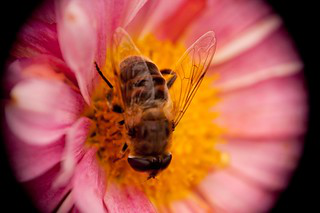

320

213

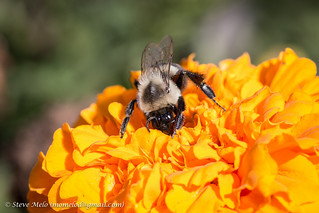

319

213

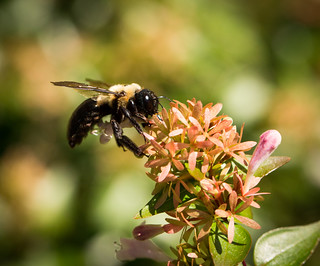

320

266

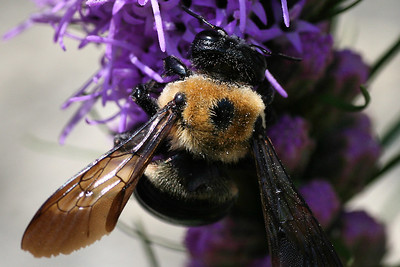

400

267

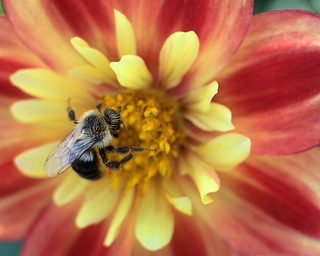

320

256

In [3]:
for p in labels_concat['path'][0:5]:
    im = Image.open('D:\\Python\\bee_or_wasp\\kaggle_bee_vs_wasp\\{}'.format(p))
    width, height = im.size
    display(im, width, height)
#  im = Image.open('D:\\Python\\bee_or_wasp\\kaggle_bee_vs_wasp\\{}'.format(labels_concat['path'][0:5]))
#  width, height = im.size

Now we will import all images and preprocessed them - resize original images to one size for all dataset (also an option to convert images into grey scale).
Once imported, we will stack the resulting arrays into a single matrix and assign it to X.

In [4]:
image_paths = list(labels_concat.path)
image_new_paths = []

def process_image(path):
    #Load the image with Image.open and create paths to save our images to
    img = Image.open('D:\\Python\\bee_or_wasp\\kaggle_bee_vs_wasp\\{}'.format(path))
    
     # create paths to save files to
    #bw_path = "D:\\Python\\bee_or_wasp\\kaggle_bee_vs_wasp\\saved_images\\bw\\bw_{}.jpg".format(path.stem)
    rcz_path = "D:\\Python\\bee_or_wasp\\kaggle_bee_vs_wasp\\saved_images\\rsz\\rsz_{}.jpg".format(path.stem)
    
    #create bw images
    #bw = img.convert("L")
    #bw.save(bw_path)
    
    #resize images and safe them to created path
    rcz = img.resize((50, 50))
    rcz.save(rcz_path)
    
    image_new_paths.append(rcz_path)
    return image_new_paths
    
# for loop over image paths
for img_path in image_paths:
    process_image(Path(img_path))
    
labels_concat['rsz_path'] = image_new_paths

# create empty list
image_list = []

for i in labels_concat.rsz_path:
    # load image
    img = io.imread(i).astype(np.float64)  
    # append to list of all images
    image_list.append(img)
    
# convert image list to single array
X = np.array(image_list)
y = labels_concat.is_bee

print(X.shape)
print(y.shape)

(2000, 50, 50, 3)
(2000,)


Now we need to normalize our image data. Normalization is a general term that means changing the scale of our data so it is consistent.

In this case, we want each feature to have a similar range so our neural network can learn effectively across all the features. As explained in the sklearn docs, "If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."

We will scale our data so that it has a mean of 0 and standard deviation of 1. We'll use sklearn's StandardScaler to do the math for us, which entails taking each value, subtracting the mean, and then dividing by the standard deviation. We need to do this for each color channel (i.e. each feature) individually.

In [5]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim,
                                                   y_interim, 
                                                   test_size=0.4,
                                                   random_state=52)

# initialize standard scaler
ss = StandardScaler()

def scale_features(train_features, test_features):
    for image in train_features:
        # for each channel, apply standard scaler's fit_transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.fit_transform(image[:, :, channel])
    for image in test_features:
        # for each channel, apply standard scaler's transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.fit_transform(image[:, :, channel])

# apply scale_features to four sets of features
scale_features(x_interim, x_eval)
scale_features(x_train, x_test)

It's time to start building our deep learning model, a convolutional neural network (CNN). CNNs are a specific kind of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, i.e., that pixels close to each other are often related.

Building a CNN begins with specifying the model type. We'll use a Sequential model, which is a linear stack of layers. We'll then add two convolutional layers. To understand convolutional layers, imagine a flashlight being shown over the top left corner of the image and slowly sliding across all the areas of the image, moving across the image in the same way your eyes move across words on a page. Convolutional layers pass a kernel (a sliding window) over the image and perform element-wise matrix multiplication between the kernel values and the pixel values in the image.

In [6]:
# set model constants
num_classes = 1

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())

We'll add the following layers:

MaxPooling. This passes a (2, 2) moving window over the image and downscales the image by outputting the maximum value within the window.

Conv2D. This adds a third convolutional layer since deeper models, i.e. models with more convolutional layers, are better able to learn features from images

Dropout. This prevents the model from overfitting, i.e. perfectly remembering each image, by randomly setting 25% of the input units to 0 at each update during training.

Flatten. As its name suggests, this flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.

Dense. Fully connected layer where every input is connected to every output (see image below).

Dropout. Another dropout layer to safeguard against overfitting, this time with a rate of 50%.

Dense. Final layer which calculates the probability the image is either a bumble bee or honey bee.

In [7]:
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))

# third convolutional layer with 64 filters
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

#model.add(BatchNormalization())
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))

# forth convolutional layer with 256 filters
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2))) #the last change

# add dropout to prevent over fitting
model.add(Dropout(0.25))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.50))

# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0

Now that we've specified the model architecture, we will compile the model for training. For this we need to specify the loss function (what we're trying to minimize), the optimizer (how we want to go about minimizing the loss), and the metric (how we'll judge the performance of the model).

Then, we'll call .fit to begin the trainig the process.

In [8]:
#stopper for keras to monitor val_loss increasing
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

my_model = model.fit(
    x_train,
    y_train,
    epochs=200,
    verbose=1,
    validation_data=(x_test, y_test),
    # set stopper
    callbacks=[callback]
)

Epoch 1/200
30/30 [==============================] - 8s 236ms/step - loss: 0.7732 - accuracy: 0.4979 - val_loss: 0.6911 - val_accuracy: 0.5547
Epoch 2/200
30/30 [==============================] - 6s 204ms/step - loss: 0.7549 - accuracy: 0.4802 - val_loss: 0.6893 - val_accuracy: 0.5813
Epoch 3/200
30/30 [==============================] - 7s 228ms/step - loss: 0.7133 - accuracy: 0.5323 - val_loss: 0.6882 - val_accuracy: 0.5781
Epoch 4/200
30/30 [==============================] - 7s 240ms/step - loss: 0.7165 - accuracy: 0.5146 - val_loss: 0.6880 - val_accuracy: 0.5516
Epoch 5/200
30/30 [==============================] - 8s 274ms/step - loss: 0.7096 - accuracy: 0.5479 - val_loss: 0.6845 - val_accuracy: 0.5813
Epoch 6/200
30/30 [==============================] - 8s 253ms/step - loss: 0.6945 - accuracy: 0.5125 - val_loss: 0.6824 - val_accuracy: 0.6000
Epoch 7/200
30/30 [==============================] - 7s 250ms/step - loss: 0.7052 - accuracy: 0.5260 - val_loss: 0.6810 - val_accuracy: 0.5953

Epoch 58/200
30/30 [==============================] - 7s 246ms/step - loss: 0.5004 - accuracy: 0.7656 - val_loss: 0.5694 - val_accuracy: 0.7203
Epoch 59/200
30/30 [==============================] - 7s 230ms/step - loss: 0.4830 - accuracy: 0.7740 - val_loss: 0.5730 - val_accuracy: 0.7188
Epoch 60/200
30/30 [==============================] - 7s 233ms/step - loss: 0.4960 - accuracy: 0.7615 - val_loss: 0.5671 - val_accuracy: 0.7094
Epoch 61/200
30/30 [==============================] - 7s 235ms/step - loss: 0.4958 - accuracy: 0.7698 - val_loss: 0.5691 - val_accuracy: 0.7109
Epoch 62/200
30/30 [==============================] - 7s 234ms/step - loss: 0.4833 - accuracy: 0.7708 - val_loss: 0.5769 - val_accuracy: 0.7109
Epoch 63/200
30/30 [==============================] - 7s 234ms/step - loss: 0.4937 - accuracy: 0.7552 - val_loss: 0.5691 - val_accuracy: 0.7156
Epoch 64/200
30/30 [==============================] - 7s 249ms/step - loss: 0.4770 - accuracy: 0.7844 - val_loss: 0.5660 - val_accuracy:

Epoch 115/200
30/30 [==============================] - 7s 235ms/step - loss: 0.3676 - accuracy: 0.8490 - val_loss: 0.5584 - val_accuracy: 0.7234
Epoch 116/200
30/30 [==============================] - 7s 226ms/step - loss: 0.3558 - accuracy: 0.8552 - val_loss: 0.5513 - val_accuracy: 0.7359
Epoch 117/200
30/30 [==============================] - 7s 227ms/step - loss: 0.3648 - accuracy: 0.8542 - val_loss: 0.5486 - val_accuracy: 0.7266
Epoch 118/200
30/30 [==============================] - 7s 226ms/step - loss: 0.3571 - accuracy: 0.8521 - val_loss: 0.5521 - val_accuracy: 0.7141
Epoch 119/200
30/30 [==============================] - 7s 230ms/step - loss: 0.3607 - accuracy: 0.8562 - val_loss: 0.5516 - val_accuracy: 0.7312
Epoch 120/200
30/30 [==============================] - 7s 250ms/step - loss: 0.3631 - accuracy: 0.8510 - val_loss: 0.5500 - val_accuracy: 0.7297
Epoch 121/200
30/30 [==============================] - 7s 248ms/step - loss: 0.3426 - accuracy: 0.8656 - val_loss: 0.5505 - val_ac

In addition to scoring the final iteration of the pre-trained model as we just did, we can also see the evolution of scores throughout training thanks to the History object. We'll use the pickle library to load the model history and then plot it.

Notice how the accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the validation loss as times goes on (a U shape in the plot), we'd suspect that the model was starting to memorize the test set and would not generalize well to new data.

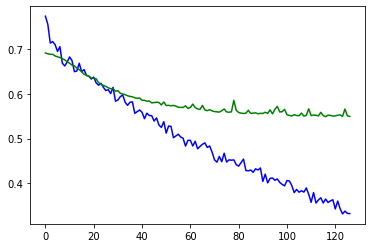

In [9]:
# Extract the history from the training object
history = my_model.history

# Plot the training loss 
plt.plot(history['loss'], label='train_loss', color = 'blue')
# Plot the validation loss
plt.plot(history['val_loss'], label='validation_loss', color = 'green')

# Show the figure
plt.show()

Let's use the evaluate method to see how well the model did at classifying bumble bees and honey bees for the test and validation sets. Recall that accuracy is the number of correct predictions divided by the total number of predictions. Given that our classes are balanced, a model that predicts 1.0 for every image would get an accuracy around 0.5.

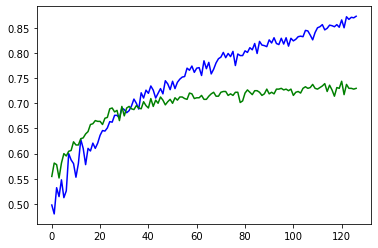

In [10]:
# Plot the training accuracy
plt.plot(history['accuracy'], label='accuracy', color = 'blue')
# Plot the validation accyracy
plt.plot(history['val_accuracy'], label='validation_accuracy', color = 'green')

# Show the figure
plt.show()

In addition to scoring the final iteration of the pre-trained model as we just did, we can also see the evolution of scores throughout training thanks to the History object. We'll use the pickle library to load the model history and then plot it.

Notice how the accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the validation loss as times goes on (a U shape in the plot), we'd suspect that the model was starting to memorize the test set and would not generalize well to new data.

In [11]:
# load pre-trained model
pretrained_cnn = model

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval, y_eval, verbose=0)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

Test loss: 0.5491440892219543
Test accuracy: 0.729687511920929

Eval loss: 0.5516351461410522
Eval accuracy: 0.7124999761581421


In [12]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)

print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:5])
print("")

13/13 [==============================] - 1s 58ms/step
First five probabilities:
[[0.96899027]
 [0.92663604]
 [0.3384124 ]
 [0.00580674]
 [0.6403766 ]]

First five class predictions:
[[1]
 [1]
 [0]
 [0]
 [1]]

